Data set: Diabetes 130-US hospitals for years 1999-2008

In [120]:
## R version:
# version
# install.packages(c("Hmisc","GGally","corrplot","psych","proto","gsubfn","sqldf","survey","e1071","CORElearn"))
# install.packages("qcc")

In [ ]:
# Librerias requeridas:

library(dplyr)
library(proto)
library(RSQLite)
library(gsubfn)
library(sqldf)
library(lattice)
library(GGally)
library(ggplot2)
library(corrplot)
library(psych)
library(randomForest)
library(e1071)
library(nnet)
library(CORElearn)
#library(lasso2)
library(survival)
library(grid)
library(Matrix)
library(survey)
library(caret)
library(rpart)
library(Hmisc)

Cargando los datos originales alojados en el repositorio **UCI**:

In [19]:
# filename="G:\\Unidades compartidas\\Books_and_Code_for_Colab_(R and Python)\\ifood_technical_test\\Analysis-HbA1c-Measurement-and-Hospital-Readmission-Rates_R\\diabetic_data.csv"
filename = 'G:/Shared drives/Books_and_Code_for_Colab_(R and Python)/ifood_technical_test/Analysis-HbA1c-Measurement-and-Hospital-Readmission-Rates_R/diabetic_data.csv'
data = read.table(filename, sep = ",", header = T, na.strings = "?")

In [10]:
## Number of rows:
print(nrow(data))
head(data)

[1] 101766


encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted
2278392,8222157,Caucasian,Female,[0-10),NA,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),NA,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),NA,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),NA,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),NA,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
35754,82637451,Caucasian,Male,[50-60),NA,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [27]:
# Examples:
data[data$patient_nbr==100000170,c("patient_nbr","encounter_id","readmitted")]

data[data$patient_nbr==100021914,c("patient_nbr","encounter_id","readmitted")]


,patient_nbr,encounter_id,readmitted
83818,100000170,263108742,>30
85608,100000170,271365276,NO


,patient_nbr,encounter_id,readmitted
69488,100021914,197661240,<30
69765,100021914,199045416,<30
70105,100021914,200455056,>30
71375,100021914,206730024,NO


In [29]:
# Hmisc::describe(data$patient_nbr)

In [19]:
length(unique(data$patient_nbr))
length(unique(data$encounter_id))
(names(data))

[1] 71518

[1] 101766

[1] "encounter_id"             "patient_nbr"             
 [3] "race"                     "gender"                  
 [5] "age"                      "weight"                  
 [7] "admission_type_id"        "discharge_disposition_id"
 [9] "admission_source_id"      "time_in_hospital"        
[11] "payer_code"               "medical_specialty"       
[13] "num_lab_procedures"       "num_procedures"          
[15] "num_medications"          "number_outpatient"       
[17] "number_emergency"         "number_inpatient"        
[19] "diag_1"                   "diag_2"                  
[21] "diag_3"                   "number_diagnoses"        
[23] "max_glu_serum"            "A1Cresult"               
[25] "metformin"                "repaglinide"             
[27] "nateglinide"              "chlorpropamide"          
[29] "glimepiride"              "acetohexamide"           
[31] "glipizide"                "glyburide"               
[33] "tolbutamide"              "pioglitazone"            
[35] "rosiglitazone"            "acarbose"                
[37] "miglitol"                 "troglitazone"            
[39] "tolazamide"               "examide"                 
[41] "citoglipton"              "insulin"                 
[43] "glyburide.metformin"      "glipizide.metformin"     
[45] "glimepiride.pioglitazone" "metformin.rosiglitazone" 
[47] "metformin.pioglitazone"   "change"                  
[49] "diabetesMed"              "readmitted"

In [20]:
## Realizando una copias de los datos originales:
original_data=data
dim(original_data)

[1] 101766     50

### Análisis de valores perdidos.

Eliminando algunas columnas: De acuerdo con el artículo de **Chopra et al**(2017), tan solo 25 varianles son consideradas de alto impacto sobre la tasa de readmitidos.

In [21]:
data=select(data, -encounter_id,  -weight,-payer_code, -(25:41),-(43:47))
dim(data)

[1] 101766     25

In [23]:
any(is.na(data$race))
any(is.na(data$medical_specialty))

[1] TRUE

[1] TRUE

In [26]:
# refactor speciality to include "Missing" as a factor level
# and replace NA with "None"

levels <- levels(data$race)
levels[length(levels) + 1] <- "Missing"

data$race <- factor(data$race, levels = levels)
data$race[is.na(data$race)] <- "Missing"

levels <- levels(data$medical_specialty)
levels[length(levels) + 1] <- "Missing"

data$medical_specialty <- factor(data$medical_specialty, levels = levels)
data$medical_specialty[is.na(data$medical_specialty)] <- "Missing"

any(is.na(data$race))

any(is.na(data$medical_specialty))

[1] FALSE

[1] FALSE

In [30]:
Hmisc::describe(data$medical_specialty)

data$medical_specialty 
       n  missing distinct 
  101766        0       73 

lowest : AllergyandImmunology     Anesthesiology           Anesthesiology-Pediatric Cardiology               Cardiology-Pediatric    
highest: Surgery-Thoracic         Surgery-Vascular         SurgicalSpecialty        Urology                  Missing                 

### Pre procesamiento de datos

Los datos tal y como están en los archivos originales no pueden ser usados debido a que se deben desacartar algunos pacientes y realizar varios cruces entre variables.

Preprocesammiento datos con SQL, fusionammiento de clases para la variable A1Cresult y readmitted. Filtrado de pacienets fallecidos o con destino a otros centros hospitalarios.

In [43]:
data = sqldf("select *, count(distinct patient_nbr) as a from data where discharge_disposition_id not in (11, 13, 14, 19, 20, 21) group by patient_nbr")

data = sqldf("select case A1Cresult when '>7' then 'Norm' when '>8' then 'High' else A1Cresult end as HbA1c, case readmitted when '<30' then 1 else 0 end as Readmit, * from data")

data = select(data, -readmitted, -patient_nbr, -a, -A1Cresult, -num_lab_procedures)

In [61]:
names(data)

[1] "HbA1c"                    "Readmit"                 
 [3] "race"                     "gender"                  
 [5] "age"                      "admission_type_id"       
 [7] "discharge_disposition_id" "admission_source_id"     
 [9] "time_in_hospital"         "medical_specialty"       
[11] "num_procedures"           "num_medications"         
[13] "number_outpatient"        "number_emergency"        
[15] "number_inpatient"         "diag_1"                  
[17] "diag_2"                   "diag_3"                  
[19] "number_diagnoses"         "max_glu_serum"           
[21] "insulin"                  "change"                  
[23] "diabetesMed"

Recodificando los tres **tipos de diagnósticos** y las **especialidades médicas**

In [65]:
data = sqldf("select case when diag_3 between 250 and 251 then 'Diabetes' when diag_3 between 390 and 459 then 'Circulatory' when diag_3==785 then 'Circulatory' when diag_3 between 460 and 519 then 'Respiratory' when diag_3==786 then 'Respiratory' when diag_3 between 520 and 579 then 'Digestive' when diag_3==787 then 'Digestive' when diag_3 between 800 and 999 then 'Injury' when diag_3 between 710 and 739 then 'Musculoskeletal' when diag_3 between 580 and 629 then 'Genitourinary' when diag_3==788 then 'Genitourinary' when diag_3 between 140 and 239 then 'Neoplasms' else 'Others' end as Diag3, * from data")

data = sqldf("select case when diag_2 between 250 and 251 then 'Diabetes' when diag_2 between 390 and 459 then 'Circulatory' when diag_2==785 then 'Circulatory' when diag_2 between 460 and 519 then 'Respiratory' when diag_2==786 then 'Respiratory' when diag_2 between 520 and 579 then 'Digestive' when diag_2==787 then 'Digestive' when diag_2 between 800 and 999 then 'Injury' when diag_2 between 710 and 739 then 'Musculoskeletal' when diag_2 between 580 and 629 then 'Genitourinary' when diag_2==788 then 'Genitourinary' when diag_2 between 140 and 239 then 'Neoplasms' else 'Others' end as Diag2, * from data")

data = sqldf("select case when diag_1 between 250 and 251 then 'Diabetes' when diag_1 between 390 and 459 then 'Circulatory' when diag_1==785 then 'Circulatory' when diag_1 between 460 and 519 then 'Respiratory' when diag_1==786 then 'Respiratory' when diag_1 between 520 and 579 then 'Digestive' when diag_1==787 then 'Digestive' when diag_1 between 800 and 999 then 'Injury' when diag_1 between 710 and 739 then 'Musculoskeletal' when diag_1 between 580 and 629 then 'Genitourinary' when diag_1==788 then 'Genitourinary' when diag_1 between 140 and 239 then 'Neoplasms' else 'Others' end as Diag1, * from data")

data = sqldf("select case when medical_specialty like 'Surgery%' then 'Surgery' else medical_specialty end as MedicalSpeciality, * from data ")

data$MedicalSpeciality <- as.factor(data$MedicalSpeciality)
data = select(data, -medical_specialty)

data_full = data

In [69]:
dim((data))

[1] 69990    26

Convirtiendo en **factores** algunas columnas correspondientes a variables categóricas.

In [70]:
data$Readmit <- as.factor(data$Readmit)
data$race <- as.factor(data$race)
data$Diag1 <- as.factor(data$Diag1)
data$Diag2 <- as.factor(data$Diag2)
data$Diag3 <- as.factor(data$Diag3)
data$HbA1c <- as.factor(data$HbA1c)
data$MedicalSpeciality <-as.factor(data$MedicalSpeciality)

### Gráficos descriptivos y exploratorios.

[1] "AfricanAmerican" "Asian"           "Caucasian"       "Hispanic"       
[5] "Other"           "Missing"

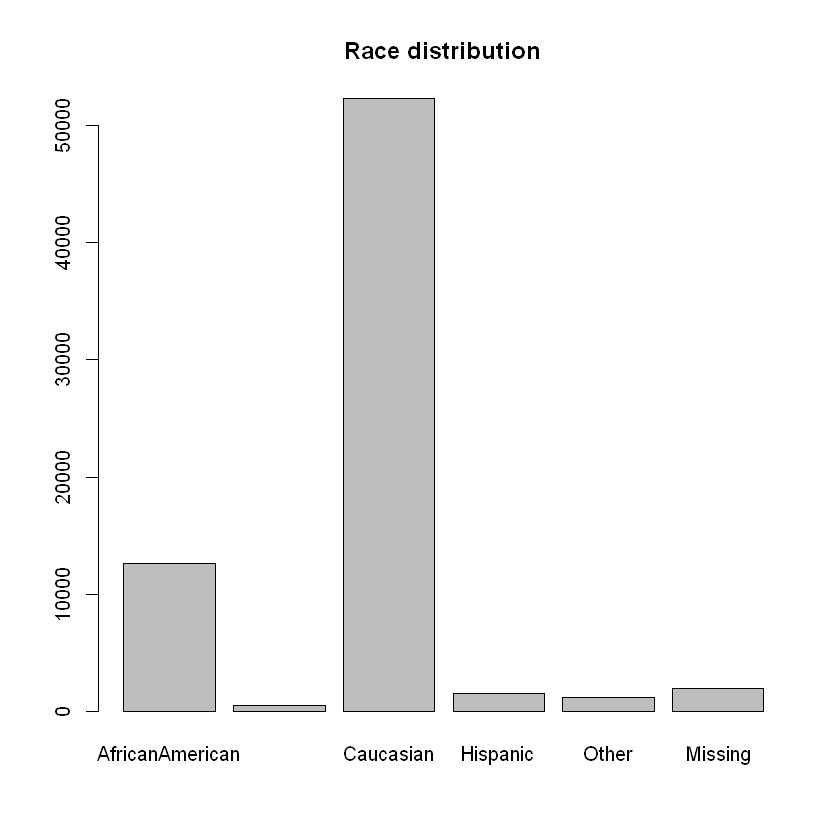

In [44]:
levels(data$race)
plot(data$race, main = "Race distribution")

Del grafico se puede observar la dominancia de la raza `Caucasian`y la introducción de una nueva categoría llamada `Missing`, la cual representa una pequeña procorción del total de casos.

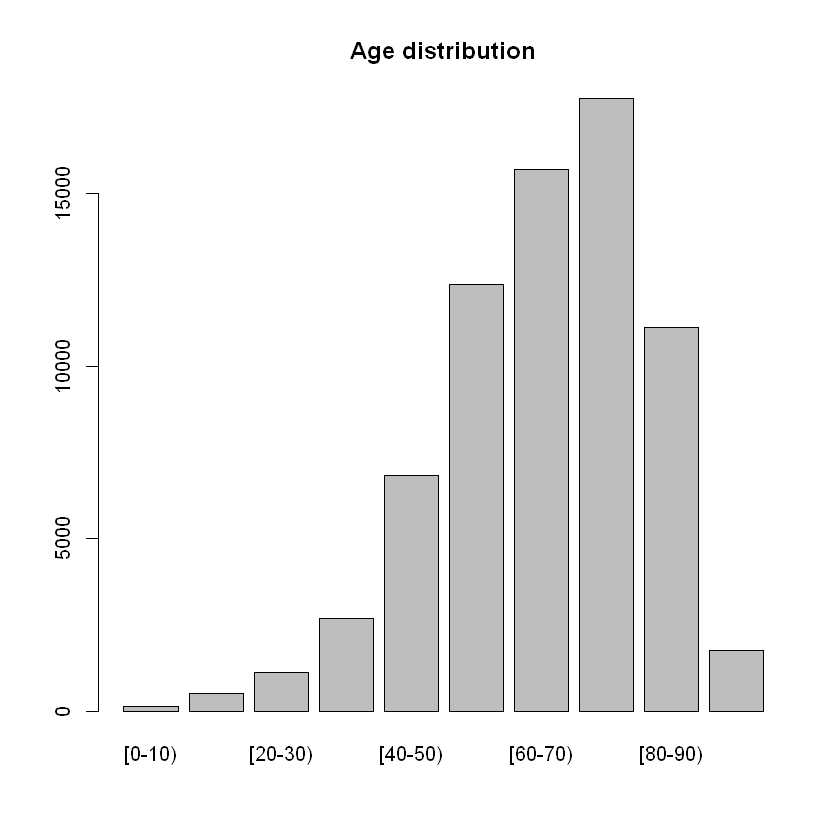

In [45]:
plot(data$age, main = "Age distribution")

La gráfica de la **edad** (categorizada pr intervalos de 10 años) muestra que la gran mayoría de los pacientes están en el rango de los 40 a los 80 años.

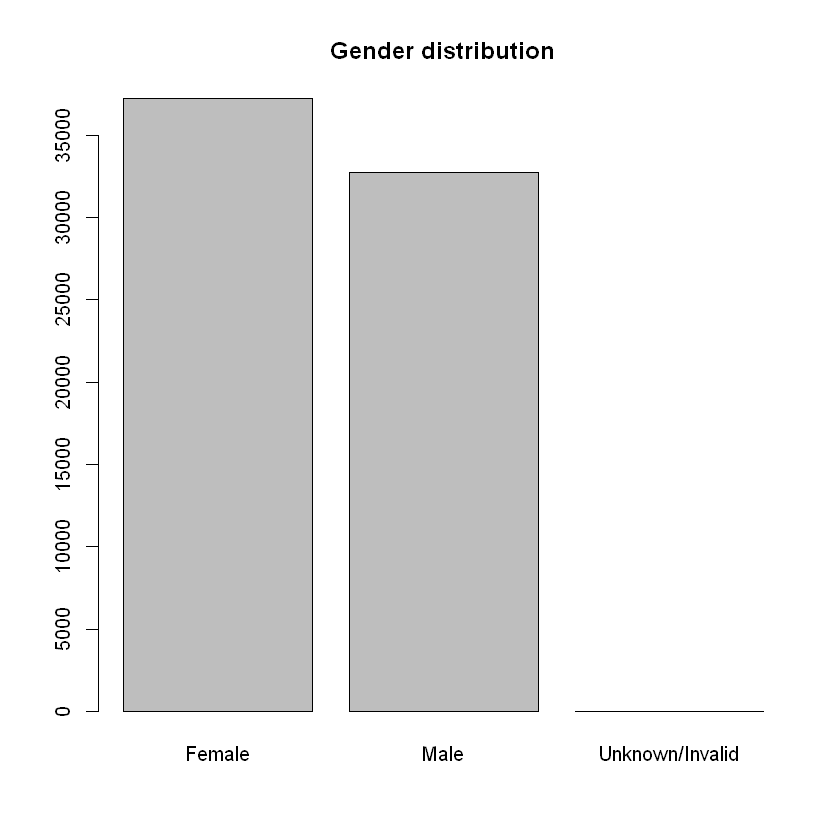

In [46]:
plot(data$gender, main = "Gender distribution") 

La gráfica del **género** muestra una ligera superioridad en fecuencia para el género `femenino` además de unos pocos pacienntes a quienes NO se les registró esta variable.

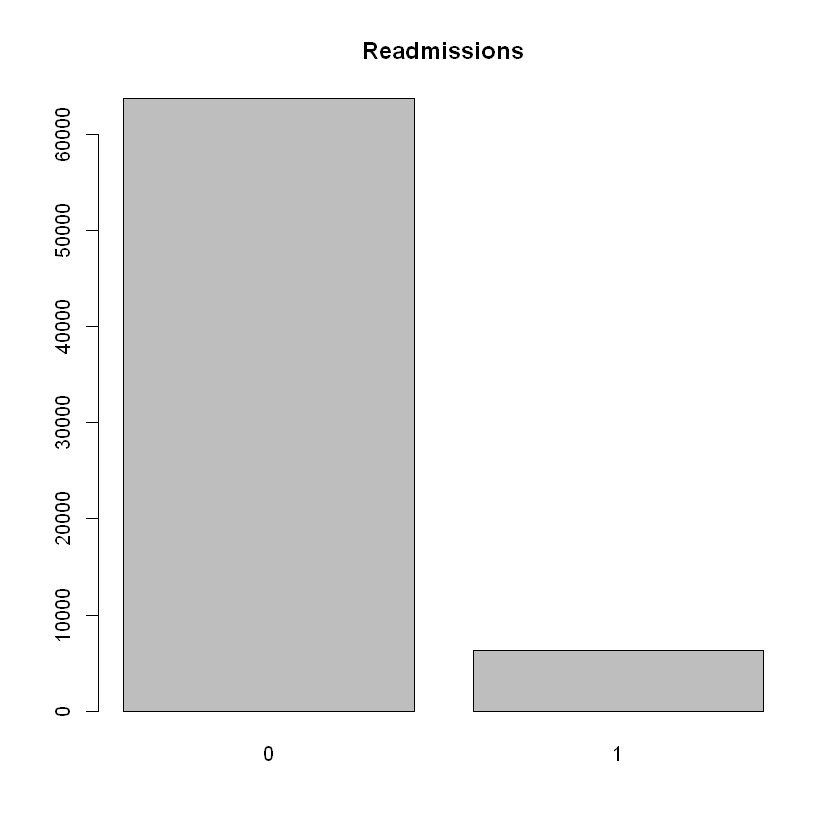

In [71]:
barplot(table(data$Readmit), main = "Readmissions") 

El gráfico de la variable **readmitted** muestra que le porcentaje de personas radmitidas anntes de 30 días (grupo objetivo) es extremadamente pequeño, por lo cual hay un gran **problema de desbalanceo** si se considera construir un modelo de clasifiación.

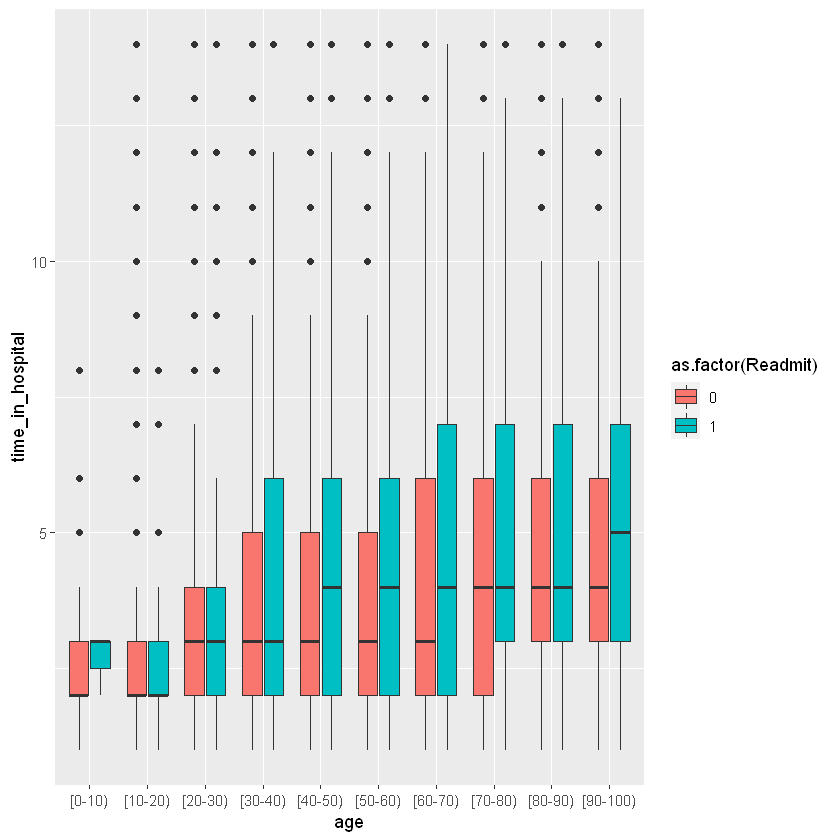

In [72]:
g <- ggplot(data, aes(x=age, y=time_in_hospital))
g + geom_boxplot(aes(fill=  as.factor(Readmit)   ))

El gráfico anterior muestra la relación entre el **número de días interno** para cada paciente contra su **edad** y su condición de **readmitido**. Cabe resaltar como los pacienntes readmitidos antes de 30 días muestran las distribuciones más segadas, lo cual se podría interpretar como:

**Entre más días demore un paciente hopitalizado, más propenso es a ser readmitido**

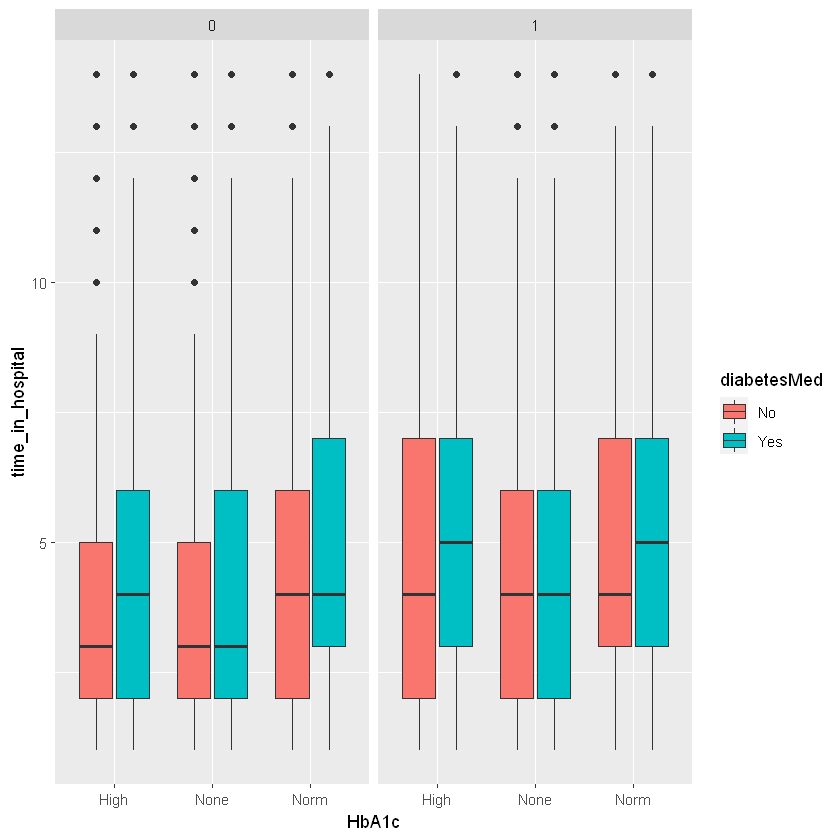

In [62]:
g <- ggplot(data,aes(x=HbA1c, y=time_in_hospital))
g + geom_boxplot(aes(fill=diabetesMed)) + facet_grid(. ~ as.factor(Readmit) )

El gráfico anterior muestra que además de pasar (en promedio) **más dias hospitalizados**, los pacientes reingresados tienen valores altos en la **prueba de hemoglobina glicosilada** (HbA1c) y además recibieron **medicamentos** para la diabetes.

In [103]:
library(qcc)
Pareto=as.data.frame(pareto.chart(table(data$MedicalSpeciality),plot=F))
names(Pareto)=c("MedicalSpeciality","FrequencyType", "Value")
head(Pareto[Pareto$FrequencyType=="Cum.Percent.",])
#plot(data$MedicalSpeciality, main="Medical Speciality")

,MedicalSpeciality,FrequencyType,Value
184,Missing,Cum.Percent.,48.08401
185,InternalMedicine,Cum.Percent.,63.28761
186,Family/GeneralPractice,Cum.Percent.,70.40006
187,Emergency/Trauma,Cum.Percent.,76.67667
188,Cardiology,Cum.Percent.,82.68896
189,Surgery,Cum.Percent.,87.95399


La tabla y el **diagrama de Pareto** muestran que casi la mitad de los registros no tiene una especialidad médica registrada (`Missing`) y junto con las 4 categorías **InternalMedicine**, **Family/GeneralPractice**, **Emergency/Trauma** y **Cardiology** acumulan alrededor del $82\%$ de los casos

numeric(0)

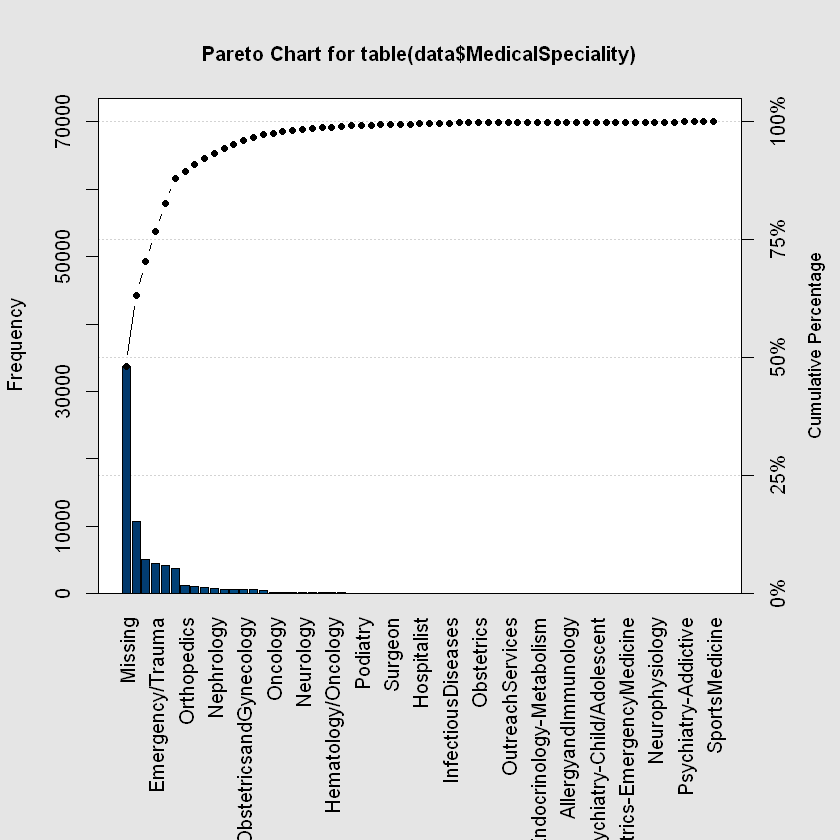

In [104]:
pareto.chart(table(data$MedicalSpeciality),plot=T)[0]

A continuación se mustran los gráficos para los tres tipos de diagnósticos:

numeric(0)

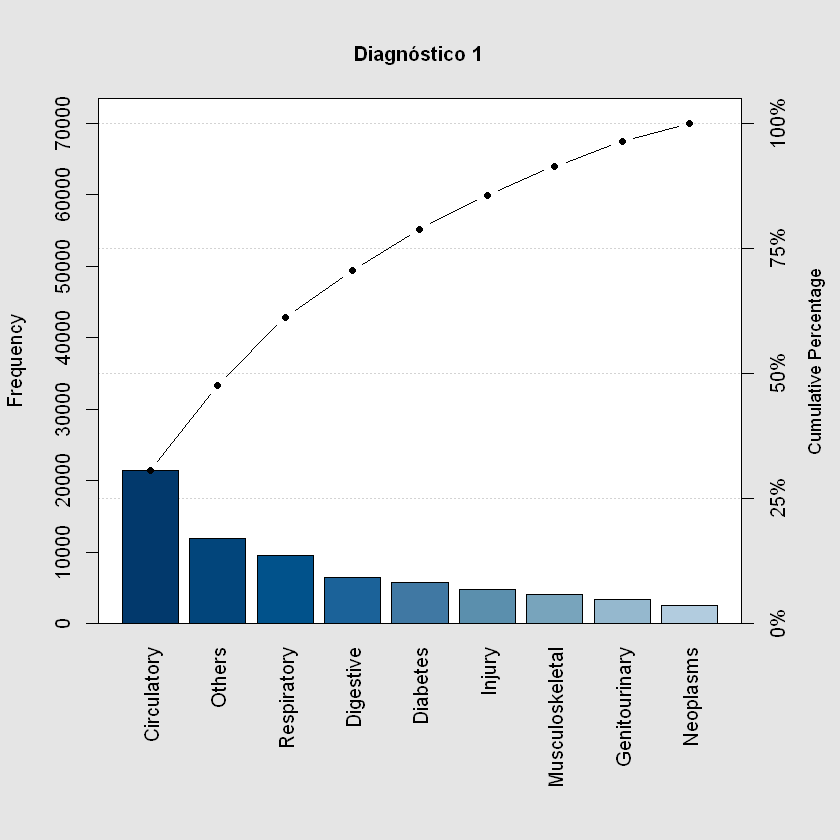

In [111]:
# par(mfrow = c(3,1))
pareto.chart(table(data$Diag1),plot=T,main="Diagnóstico 1")[0]


numeric(0)

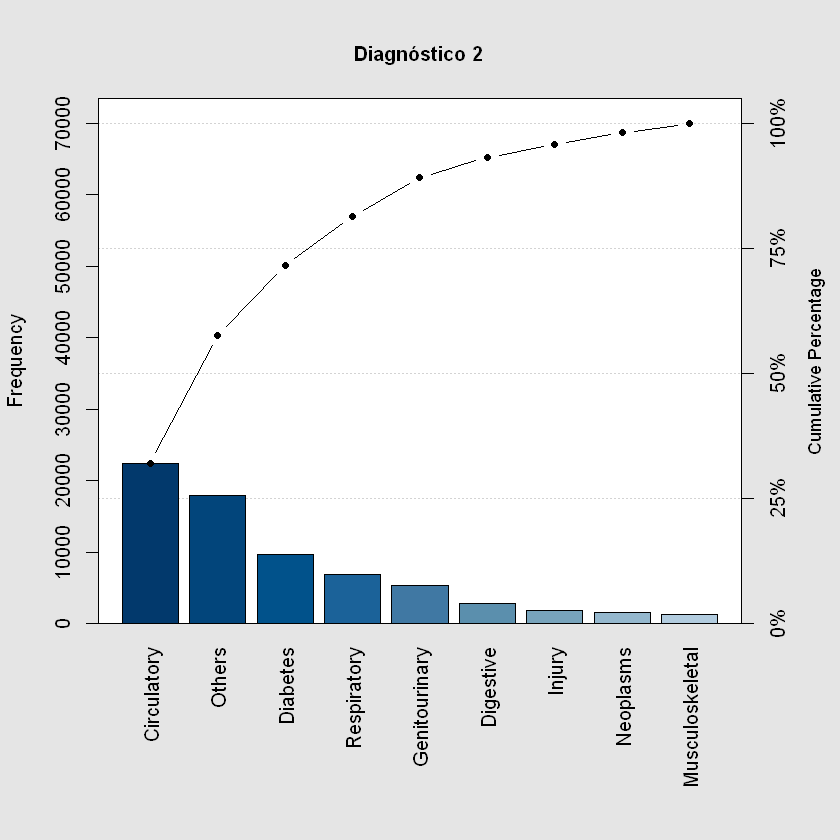

In [107]:
pareto.chart(table(data$Diag2),plot=T,main="Diagnóstico 2")[0]

numeric(0)

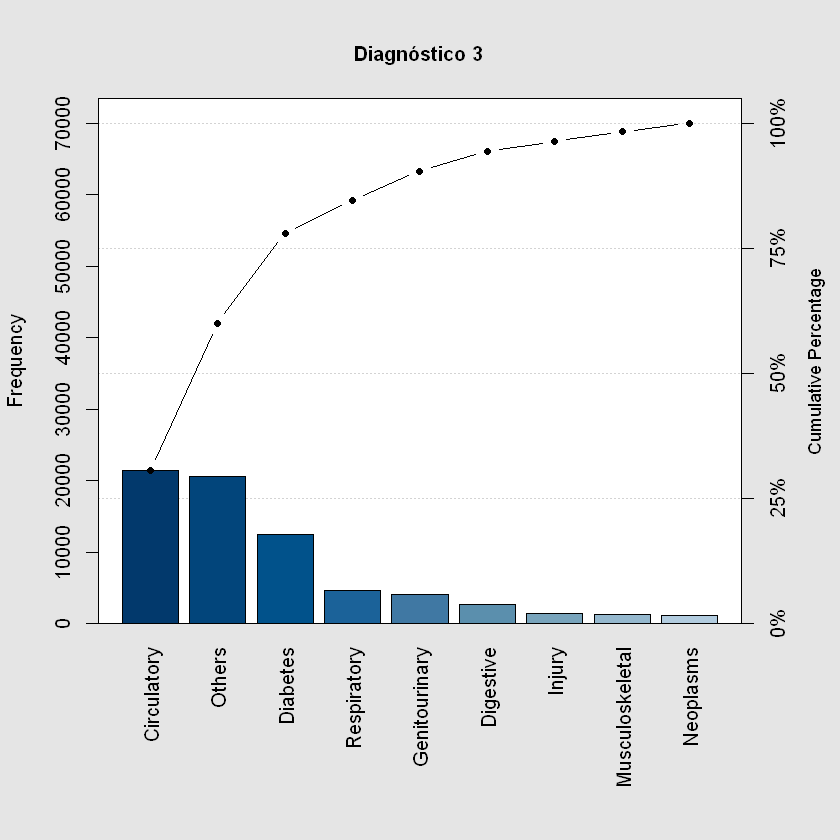

In [108]:
pareto.chart(table(data$Diag3),plot=T,main="Diagnóstico 3")[0]

De las tres gráficas se puede observar que los problemas circulatorios representan la mayor cantidad de casos para los tres diagnósticos. La **diabetes** solo cobra relevenacia como la tercera causa a partir del diagnóstico 2.

A continuación se elimminan columnas adicionales y se fusionan las columnas **HbA1c** y **change** como una sola llamada `Reaction`

In [112]:
data = select(data, -diag_1, -diag_2, -diag_3, -admission_source_id, -num_procedures, -num_medications, -number_outpatient, -number_emergency, -number_inpatient)

data = select(data, -Diag2, -Diag3, -number_diagnoses, -max_glu_serum, -insulin, -diabetesMed)

data = sqldf("select case when HbA1c is 'High' and change is 'Ch' then 'High&Ch' when HbA1c is 'High' and change is 'No' then 'High&Not' else HbA1c end as Reaction, Diag1 as Pri_diag, * from data")

# Conversión a factores
data$Reaction <- as.factor(data$Reaction)
data$race <- as.factor(data$race)
data$discharge_disposition_id <- as.factor(data$discharge_disposition_id)
data$admission_type_id <- as.factor(data$admission_type_id)

# Removiendo duplicados
data = select(data, -Diag1, -HbA1c, -change)

In [113]:
dim(data)

[1] 69990    10

In [114]:
data2 = data
data2$race<- as.factor(data2$race)
data2 = select(data2, -gender)
data2 = sqldf("select case discharge_disposition_id when 1 then 'Home' else 'Other' end as Discharge, * from data2")
data2 = sqldf("select case admission_type_id when 1 or 2 then 'Emergency' when 7 then 'referral' else 'Other' end as Admission, * from data2")
data2 = sqldf("select case race when 'AfricanAmerican' then 'AfricanAmerican' when 'Caucasian' then 'Caucasian' when 'Missing' then 'Missing' else 'Other' end as race_, * from data2")
data2 = sqldf("select case age when '[30-40)' then '[30, 60)' when '[40-50)' then '[30, 60)' when '[50-60)' then '[30, 60)' when '[0-10)' then '<30' when '[10-20)' then '<30' when '[20, 30)' then '<30' else '[60, 100)' end as Age_, * from data2")
data2 = sqldf("select case MedicalSpeciality when 'Missing' then 'Missing' when 'Cardiology' then 'Cardiology' when 'Family/GeneralPractice' then 'GeneralPractice' when 'InternalMedicine' then 'InternalMedicine' when 'Surgery' then 'Surgery' else 'Other' end as Medical_speciality, * from data2")
data2$race_<-as.factor(data2$race_)
data2$Admission<-as.factor(data2$Admission)
data2$Discharge<-as.factor(data2$Discharge)
data2$Pri_diag <- as.factor(data2$Pri_diag)
data2$Age_ <- as.factor(data2$Age_)
data2$Medical_speciality <- as.factor(data2$Medical_speciality)
data2 = select(data2, -race, -admission_type_id, -discharge_disposition_id, -age, -MedicalSpeciality)
head(data2)

Medical_speciality,Age_,race_,Admission,Discharge,Reaction,Pri_diag,Readmit,time_in_hospital
Cardiology,"[30, 60)",Caucasian,Other,Home,None,Circulatory,1,8
Surgery,"[30, 60)",Caucasian,Other,Home,None,Musculoskeletal,0,2
InternalMedicine,"[60, 100)",Caucasian,Emergency,Other,Norm,Injury,0,4
InternalMedicine,"[60, 100)",Caucasian,Emergency,Home,High&Ch,Others,0,3
InternalMedicine,"[30, 60)",AfricanAmerican,Emergency,Home,None,Genitourinary,0,5
Other,"[30, 60)",AfricanAmerican,Emergency,Home,None,Others,0,6


In [119]:
dim(data2)
c('race','gender','age','discharge_disposition_id','admission_source_id','time_in_hospital','medical_specialty','diag_1','A1Cresult','change','readmitted')

[1] 69990     9

[1] "race"                     "gender"                  
 [3] "age"                      "discharge_disposition_id"
 [5] "admission_source_id"      "time_in_hospital"        
 [7] "medical_specialty"        "diag_1"                  
 [9] "A1Cresult"                "change"                  
[11] "readmitted"

Finalmente se exporta el conjunto de datos a utilizar para la **etapa de modelamiento**:

In [124]:
write.csv(data2,'diabetic_data_cleaned.csv', row.names = FALSE)